In [1]:
# Welcome to your new notebook
# Type here in the cell editor to add code!



StatementMeta(, f97326c7-9162-4aa4-9db2-d03770cad977, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 0352b249-c254-4c05-8938-63b3ec068f1f)

In [1]:

df = spark.read.format("csv").option("header","true").load("Files/Merged_Company_Table.csv")
# df now is a Spark DataFrame containing CSV data from "Files/Merged_Company_Table.csv".
display(df)

StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b988e687-0d3e-41ab-992e-0545b53e21d3)

In [5]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import DoubleType



StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 7, Finished, Available, Finished)

In [6]:
# Replace missing values with default values
df = df.fillna({
    "DistanceKM": 0,
    "UnitsProduced": 0,
    "DeliveryCount": 0,
    "AverageCO2PerKM": 0,
    "AvgCO2PerUnit": 0,
    "AvgCO2PerDelivery": 0
})


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 8, Finished, Available, Finished)

In [7]:
# Detect and remove outliers using z-scores
mean_distance = df.select(mean(col("DistanceKM"))).collect()[0][0]
std_distance = df.select(stddev(col("DistanceKM"))).collect()[0][0]
z_score_threshold = 3

df = df.filter((col("DistanceKM") - mean_distance) / std_distance < z_score_threshold)


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 9, Finished, Available, Finished)

In [9]:
from pyspark.sql.types import DoubleType

# Convert columns to numeric (double) type
df = df.withColumn("DistanceKM", col("DistanceKM").cast(DoubleType()))
df = df.withColumn("UnitsProduced", col("UnitsProduced").cast(DoubleType()))
df = df.withColumn("DeliveryCount", col("DeliveryCount").cast(DoubleType()))

# Check the schema to confirm the type changes
df.printSchema()


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 11, Finished, Available, Finished)

root
 |-- _c0: string (nullable = true)
 |-- TransactionID: string (nullable = true)
 |-- TransportID: string (nullable = true)
 |-- ProductionID: string (nullable = true)
 |-- SupplierID: string (nullable = true)
 |-- DistanceKM: double (nullable = true)
 |-- UnitsProduced: double (nullable = true)
 |-- DeliveryCount: double (nullable = true)
 |-- Mode: string (nullable = true)
 |-- FuelType: string (nullable = true)
 |-- AverageCO2PerKM: string (nullable = false)
 |-- Material: string (nullable = true)
 |-- EnergySource: string (nullable = true)
 |-- AvgCO2PerUnit: string (nullable = false)
 |-- SupplierName: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- AvgCO2PerDelivery: string (nullable = false)



In [10]:
# Assemble features for scaling
assembler = VectorAssembler(inputCols=["DistanceKM", "UnitsProduced", "DeliveryCount"], outputCol="features")
df = assembler.transform(df)

# Normalize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Show the transformed data
df.select("DistanceKM", "UnitsProduced", "DeliveryCount", "scaled_features").show(5)


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 12, Finished, Available, Finished)

+----------+-------------+-------------+--------------------+
|DistanceKM|UnitsProduced|DeliveryCount|     scaled_features|
+----------+-------------+-------------+--------------------+
|    1638.0|       1270.0|          5.0|[0.95636182468682...|
|    1860.0|        399.0|          6.0|[1.28216912167213...|
|     779.0|       4019.0|          1.0|[-0.3043069505851...|
|    1489.0|       2049.0|          7.0|[0.73768935959308...|
|     153.0|       2714.0|          9.0|[-1.2230248240662...|
+----------+-------------+-------------+--------------------+
only showing top 5 rows



## Exploratory Data Analysis (EDA)


In [11]:
# Show basic statistics
df.describe(["DistanceKM", "UnitsProduced", "DeliveryCount"]).show()


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 13, Finished, Available, Finished)

+-------+-----------------+------------------+------------------+
|summary|       DistanceKM|     UnitsProduced|     DeliveryCount|
+-------+-----------------+------------------+------------------+
|  count|               20|                20|                20|
|   mean|           986.35|            2632.3|              4.75|
| stddev|681.3843706208088|1553.8462668657512|2.5313819816144116|
|    min|             53.0|             212.0|               1.0|
|    max|           1982.0|            4893.0|               9.0|
+-------+-----------------+------------------+------------------+



In [13]:
# Drop the existing 'features' column if it exists
if "features" in df.columns:
    df = df.drop("features")

# Assemble features for scaling
assembler = VectorAssembler(inputCols=["DistanceKM", "UnitsProduced", "DeliveryCount"], outputCol="features")
df = assembler.transform(df)

# Compute the correlation matrix
from pyspark.ml.stat import Correlation
correlation_matrix = Correlation.corr(df, "features").head()[0]
print("Correlation Matrix:\n", correlation_matrix)


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 15, Finished, Available, Finished)

Correlation Matrix:
 DenseMatrix([[ 1.        , -0.38620208, -0.19773717],
             [-0.38620208,  1.        , -0.24233219],
             [-0.19773717, -0.24233219,  1.        ]])


## 4. Train Machine Learning Model


In [14]:
# Split data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 16, Finished, Available, Finished)

In [16]:
from pyspark.sql.types import DoubleType

# Cast the AverageCO2PerKM column to a numeric type
df = df.withColumn("AverageCO2PerKM", col("AverageCO2PerKM").cast(DoubleType()))

# Verify the schema to ensure the column is now numeric
df.printSchema()


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 18, Finished, Available, Finished)

root
 |-- _c0: string (nullable = true)
 |-- TransactionID: string (nullable = true)
 |-- TransportID: string (nullable = true)
 |-- ProductionID: string (nullable = true)
 |-- SupplierID: string (nullable = true)
 |-- DistanceKM: double (nullable = true)
 |-- UnitsProduced: double (nullable = true)
 |-- DeliveryCount: double (nullable = true)
 |-- Mode: string (nullable = true)
 |-- FuelType: string (nullable = true)
 |-- AverageCO2PerKM: double (nullable = true)
 |-- Material: string (nullable = true)
 |-- EnergySource: string (nullable = true)
 |-- AvgCO2PerUnit: string (nullable = false)
 |-- SupplierName: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- AvgCO2PerDelivery: string (nullable = false)
 |-- scaled_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [20]:
# Split data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Define the Random Forest model
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="AverageCO2PerKM")

# Define parameter grid
param_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 50]).build()

# Cross-validator
evaluator = RegressionEvaluator(labelCol="AverageCO2PerKM", predictionCol="prediction", metricName="rmse")
crossval = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

# Train models and select the best one
cv_model = crossval.fit(train_df)
best_model = cv_model.bestModel

# Evaluate the model
predictions = best_model.transform(test_df)
rmse = evaluator.evaluate(predictions)

print(f"Best Model: {type(best_model).__name__}")
print(f"RMSE: {rmse}")


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 22, Finished, Available, Finished)

Best Model: RandomForestRegressionModel
RMSE: 0.33692692679570774


StatementMeta(, b6b4b1c6-804e-4454-90a5-766ef1f4124b, 23, Finished, Available, Finished)

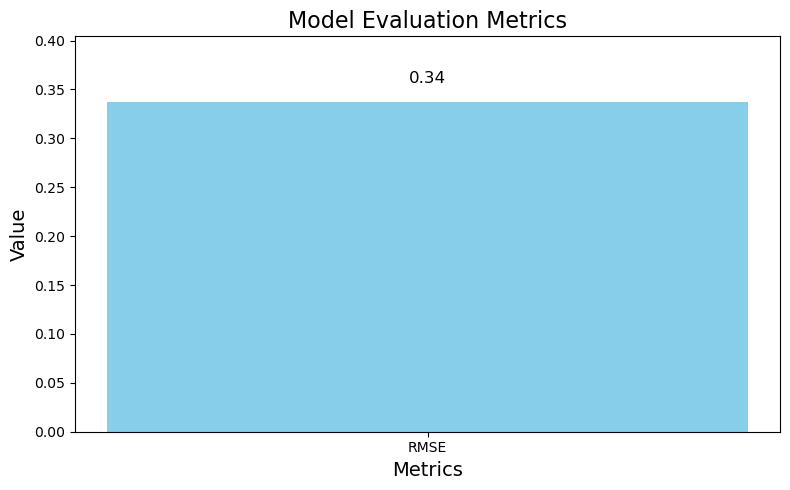

In [21]:
import matplotlib.pyplot as plt

# Ensure the metrics are within a reasonable range
metrics = {
    "RMSE": rmse if rmse < 1e6 else 0,  # Check for large/unreasonable values
}

# Plot the metrics
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Model Evaluation Metrics", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.ylim(0, max(metrics.values()) * 1.2)  # Add space above bars

# Annotate the values on top of the bars
for metric, value in metrics.items():
    plt.text(metric, value + 0.02, f"{value:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()
